In [1]:
from modules.datakit import *
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

__Read data__

In [2]:
path = f'data_processed/main.csv'
df = pd.read_csv(path)

__Deduplicate records using dedicated function__

In [4]:
df = deduplicate_main(df)

__Transform scraped data using dedicated function__

In [6]:
df = transform_data(
    main = df,
    only_expired = True,
    duration_start = 1,
    duration_end = 28,
    utilize_morf = True
)

__Correct misleading locations__

In [8]:
path = 'data_raw/manual_input/misleading_locations.csv'
df_locations = pd.read_csv(path)
df_locations = df_locations[df_locations.misleading_location.eq(True)]

real_coordinates = df_locations['maps_herf'].apply(
    lambda x: re.search('/@(.*),', x).group(1).split(','))

df_locations['latitude'] = [float(sublist[0]) for sublist in real_coordinates]
df_locations['longitude'] = [float(sublist[1]) for sublist in real_coordinates]

In [10]:
latitude_map = df_locations.set_index('link')['latitude']
longitude_map = df_locations.set_index('link')['longitude']
district_map = df_locations.set_index('link')['real_district']

df.loc[df['link'].isin(latitude_map.index), 'latitude'] = df['link'].map(latitude_map)
df.loc[df['link'].isin(longitude_map.index), 'longitude'] = df['link'].map(longitude_map)
df.loc[df['link'].isin(district_map.index), 'district'] = df['link'].map(district_map)

__Add hidden additional fees__

In [13]:
path = 'data_raw/large_language_model/llm_output.csv'
df_fees = pd.read_csv(path)

In [14]:
fees_map = df_fees.set_index('link')['real_additional_fees']
df.loc[df['link'].isin(fees_map.index), 'additional_fees'] = df['link'].map(fees_map)

__Calculate distance columns using dedicated functions__

In [16]:
ztm_stops = pd.read_csv('geographic_data/ztm_stops/ztm_stops.csv')

In [17]:
df['distance_to_stop'] = distance_to_nearest_stop(df, ztm_stops)

In [18]:
subway_stations = ztm_stops[
    ztm_stops.stop_name.str.startswith('Metro')|
    ztm_stops.stop_name.str.contains('Wilsona')|
    ztm_stops.stop_name.str.contains('Daszyńskiego')|
    ztm_stops.stop_name.str.contains('Nowy Świat')|
    ztm_stops.stop_name.str.contains('ONZ')|
    ztm_stops.stop_name.str.contains('Wileński')|
    ztm_stops.stop_name.eq('Dw. Gdański')|
    ztm_stops.stop_name.eq('Centrum')].copy()

In [19]:
df['distance_to_subway'] = distance_to_nearest_stop(df, subway_stations)

In [20]:
df['distance_to_center'] = distance_to_center(df)

__Historical data calculate average rent price per square in a radius using__

In [22]:
legacy_data = concat_csv_files(folder_path='data_raw/otodom_scraped_data_historical')

In [23]:
legacy_data = legacy_data[~legacy_data.approximate_coordinates.eq(True)]

In [24]:
columns_to_convert = ['rent_price', 'additional_fees', 'area']
for column in columns_to_convert:
    legacy_data[column] = legacy_data[column].apply(lambda x: get_numbers(str(x)))
    
legacy_data['rent_price'] = legacy_data.apply(
    lambda row: row['rent_price'] + row['additional_fees']\
    if not pd.isna(row['additional_fees']) else row['rent_price'], 
    axis=1)

legacy_data['price_per_square'] = legacy_data.rent_price/legacy_data.area

In [26]:
df['avg_price'] = average_price_within_radius(df, legacy_data, radius_km=0.5)

__Add apartment classes__

In [27]:
additional_columns = pd.read_csv('data_raw/manual_input/apartment_class.csv')

In [28]:
df = df.merge(additional_columns, on='link')

__Save data__

In [30]:
columns_to_drop = ['title', 'adv_description', 'link', 'last_update', 'location']
df.drop(columns=columns_to_drop, inplace=True)

path = 'data_processed/modeling_data.csv'
df.to_csv(path,
          encoding='utf-8',
          index=False)

__Modeling__

In [323]:
columns_to_drop = ['link', 'last_update', 'location', 'latitude', 'longitude']

modeling_df = df.copy()
modeling_df = modeling_df.drop(columns=columns_to_drop)

In [325]:
modeling_df.head(4)

,added_dt,floor,heating,advertiser_type,approximate_coordinates,elevator,building_type,safeguards,district,rent,additional_fees,area,room_number,students_allowed,non_smoker_only,building_height,for_renovation,balcony,terrace,garden,parking_space,separate_kitchen,utility_room,basement,gated_community,security_monitoring,building_age,cable_tv,internet,dishwasher,air_conditioning,distance_to_stop,distance_to_subway,distance_to_center,avg_log_price,is_furnished,apartment_class
0,2024-12-01,2.0,district,agency,0,1,tenement,0,Srodmiescie,2700,600,38.0,2.0,0,0,8.0,0,1,0,0,0,1,0,0,0,0,93.0,0,1,0,0,0.043828,0.644262,1.671,102.939267,1,basic
1,2024-12-01,10.0,district,agency,0,1,apartment,0,Wola,6900,1300,55.0,2.0,0,0,22.0,0,1,0,0,1,0,0,0,0,1,16.0,1,1,1,0,0.088196,0.332013,1.710,127.286920,1,superior
2,2024-12-01,3.0,district,owner,0,1,block_of_flats,1,Bielany,2900,770,56.0,2.0,0,1,5.0,0,1,0,0,1,0,0,0,0,0,16.0,1,1,1,0,0.430110,1.410617,10.171,82.153009,1,basic
3,2024-12-01,8.0,district,agency,0,1,other,1,Targowek,1950,736,35.0,1.0,0,0,8.0,0,0,0,0,0,0,0,0,1,0,24.0,1,1,0,0,0.176824,0.176824,7.208,81.727041,1,basic


In [327]:
input_missing_values(modeling_df)

In [329]:
df_encoded = pd.get_dummies(
    modeling_df,
    columns=['heating', 'advertiser_type', 'building_type', 'apartment_class'],
    prefix={'heating': 'heating', 'advertiser_type': 'at', 'building_type': 'bt', 'apartment_class': 'ac'},
    prefix_sep='_',
    dtype=int)

district_dummies = pd.get_dummies(df['district'], prefix='', prefix_sep='', dtype=int)
modeling_df = pd.concat([df_encoded.drop('district', axis=1), district_dummies], axis=1)

In [331]:
modeling_df.head(4)

,added_dt,floor,approximate_coordinates,elevator,safeguards,rent,additional_fees,area,room_number,students_allowed,non_smoker_only,building_height,for_renovation,balcony,terrace,garden,parking_space,separate_kitchen,utility_room,basement,gated_community,security_monitoring,building_age,cable_tv,internet,dishwasher,air_conditioning,distance_to_stop,distance_to_subway,distance_to_center,avg_log_price,is_furnished,heating_boiler room,heating_district,heating_electric,heating_gas,heating_other,at_agency,at_developer,at_owner,bt_apartment,bt_block_of_flats,bt_other,bt_tenement,ac_basic,ac_premium,ac_standard,ac_superior,Bemowo,Bialoleka,Bielany,Mokotow,Ochota,Praga_Polnoc,Praga_Poludnie,Rembertow,Srodmiescie,Targowek,Ursus,Ursynow,Wawer,Wesola,Wilanow,Wlochy,Wola,Zoliborz
0,2024-12-01,2.0,0,1,0,2700,600,38.0,2.0,0,0,8.0,0,1,0,0,0,1,0,0,0,0,93.0,0,1,0,0,0.043828,0.644262,1.671,102.939267,1,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,2024-12-01,10.0,0,1,0,6900,1300,55.0,2.0,0,0,22.0,0,1,0,0,1,0,0,0,0,1,16.0,1,1,1,0,0.088196,0.332013,1.710,127.286920,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,2024-12-01,3.0,0,1,1,2900,770,56.0,2.0,0,1,5.0,0,1,0,0,1,0,0,0,0,0,16.0,1,1,1,0,0.430110,1.410617,10.171,82.153009,1,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2024-12-01,8.0,0,1,1,1950,736,35.0,1.0,0,0,8.0,0,0,0,0,0,0,0,0,1,0,24.0,1,1,0,0,0.176824,0.176824,7.208,81.727041,1,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [333]:
modeling_df['rent'] = modeling_df['rent'] + modeling_df['additional_fees']

In [347]:
modeling_df['rent'] = np.log(modeling_df['rent'])

__-----__

In [350]:
train_df = modeling_df[modeling_df.added_dt.le('2025-01-25')].copy()
out_of_time_sample = modeling_df[modeling_df.added_dt.ge('2025-01-26')&modeling_df.added_dt.le('2025-02-04')].copy()

train_df = train_df.drop(["added_dt", 'additional_fees'], axis=1)
out_of_time_sample = out_of_time_sample.drop(["added_dt", 'additional_fees'], axis=1)

In [352]:
y_col = 'rent'
x_cols = [col for col in train_df.columns if col != y_col]

X_train = train_df.drop([y_col], axis=1)
y_train = train_df[y_col]
X_out_of_time = out_of_time_sample.drop([y_col], axis=1)
y_out_of_time = out_of_time_sample[y_col]

In [354]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_validate, RandomizedSearchCV

In [356]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error

In [358]:
params = {
    "learning_rate": 0.05,
    "max_depth": 3,
    "min_child_weight": 5,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "reg_alpha": 0.1,
    "reg_lambda": 1,
    "n_estimators": 150
}

model = XGBRegressor(**params)

cv_results = cross_validate(
    model, X_train, y_train, cv=5, scoring=["neg_mean_absolute_error", "r2", "neg_mean_absolute_percentage_error"], return_train_score=True
)

print("MAE Train:", cv_results["train_neg_mean_absolute_error"])
print("MAE Test:", cv_results["test_neg_mean_absolute_error"])
print("Mean MAE Test:", cv_results["test_neg_mean_absolute_error"].mean())
print("-------------------")
print("R2 Train:", cv_results["train_r2"])
print("R2 Test:", cv_results["test_r2"])
print("Mean R2 Test:", cv_results["test_r2"].mean())
print("-------------------")
print("MAPE Train:", cv_results["train_neg_mean_absolute_percentage_error"])
print("MAPE Test:", cv_results["test_neg_mean_absolute_percentage_error"])
print("Mean MAPE Test:", cv_results["test_neg_mean_absolute_percentage_error"].mean())

MAE Train: [-0.10708626 -0.1034891  -0.10819078 -0.10502883 -0.10430308]
MAE Test: [-0.11860366 -0.12891743 -0.10727725 -0.1192031  -0.12120383]
Mean MAE Test: -0.11904105124914784
-------------------
R2 Train: [0.87751196 0.87832462 0.87684526 0.88156818 0.88797757]
R2 Test: [0.84423047 0.83807561 0.86959967 0.84326038 0.80224524]
Mean R2 Test: 0.839482273949305
-------------------
MAPE Train: [-0.01273092 -0.01231637 -0.01282506 -0.01243857 -0.01234096]
MAPE Test: [-0.01387136 -0.01501328 -0.01275813 -0.01421376 -0.01452345]
Mean MAPE Test: -0.014075996781129793


In [359]:
# Initialize and train the model on the full training set
model = XGBRegressor(**params)
model.fit(X_train, y_train)

# Predict on the out‐of‐time sample
y_pred_oot = model.predict(X_out_of_time)

# Calculate scoring metrics for the OOT sample
mae_oot = mean_absolute_error(y_out_of_time, y_pred_oot)
r2_oot = r2_score(y_out_of_time, y_pred_oot)
mape_oot = mean_absolute_percentage_error(y_out_of_time, y_pred_oot)

# Print out the results
print("Out-of-Time Sample Scores:")
print("MAE:", mae_oot)
print("R2:", r2_oot)
print("MAPE:", mape_oot)

Out-of-Time Sample Scores:
MAE: 0.12938792070491947
R2: 0.7842180755425207
MAPE: 0.015434679137046657


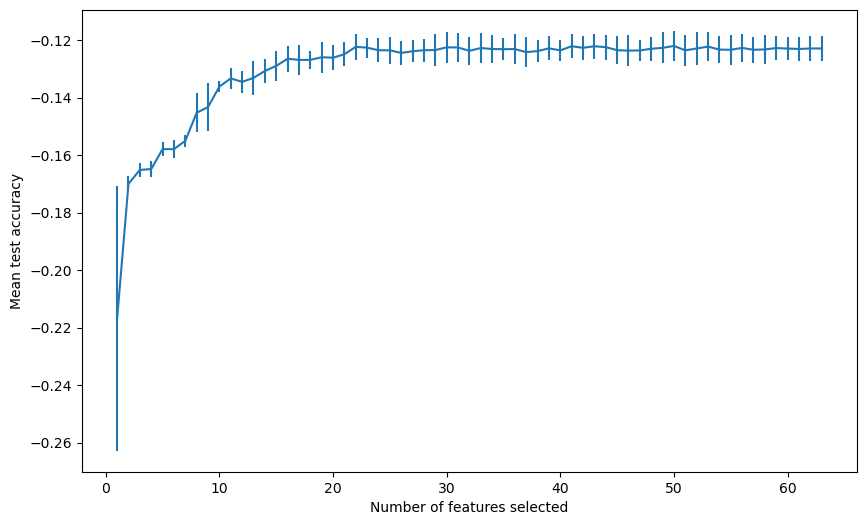

In [362]:
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold

# Initialize your XGBRegressor
xgb_reg = XGBRegressor()

# Define a cross-validation strategy
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Set up RFECV with negative mean squared error as the scoring metric.
rfecv = RFECV(estimator=xgb_reg, step=1, cv=cv, scoring='neg_mean_absolute_error')

# Fit RFECV on your training data
rfecv.fit(X_train, y_train)

n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure(figsize=(10, 6))
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(1, n_scores + 1),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.show()

In [364]:
print("Optimal number of features:", rfecv.n_features_)

Optimal number of features: 50


In [366]:
rfecv.cv_results_["mean_test_score"]

array([-0.21687802, -0.16998675, -0.16517908, -0.16486949, -0.15794248,
       -0.1579402 , -0.15505434, -0.14529374, -0.1432939 , -0.13618062,
       -0.13333441, -0.13454235, -0.13315211, -0.13076491, -0.12898682,
       -0.12650099, -0.12690908, -0.12689108, -0.12598059, -0.12614074,
       -0.12492179, -0.12236354, -0.12264492, -0.12354175, -0.12356787,
       -0.12448365, -0.12388916, -0.1235357 , -0.12348771, -0.12253124,
       -0.12258359, -0.12374426, -0.12277509, -0.12311353, -0.12317712,
       -0.12312855, -0.12419773, -0.12384193, -0.12288226, -0.12358563,
       -0.12214322, -0.12269928, -0.12215561, -0.12247216, -0.12351804,
       -0.12368326, -0.12361198, -0.12302556, -0.12272328, -0.12204063,
       -0.1235778 , -0.12293587, -0.12227473, -0.12332735, -0.12338035,
       -0.12272756, -0.12338643, -0.12326293, -0.1227839 , -0.1229613 ,
       -0.12309959, -0.12292864, -0.12292864])

In [368]:
len([-0.21687802, -0.16998675, -0.16517908, -0.16486949, -0.15794248,
       -0.1579402 , -0.15505434, -0.14529374, -0.1432939 , -0.13618062,
       -0.13333441, -0.13454235, -0.13315211, -0.13076491, -0.12898682,
       -0.12650099, -0.12690908, -0.12689108, -0.12598059, -0.12614074,
       -0.12492179, -0.12236354, -0.12264492])

23

In [370]:
from sklearn.feature_selection import RFE

model = XGBRegressor()
rfe = RFE(estimator=xgb_reg, n_features_to_select=23, step=1)
rfe.fit(X_train, y_train)

selected_features = X_train.columns[rfe.support_]
selected_features

Index(['area', 'room_number', 'terrace', 'building_age', 'dishwasher',
       'air_conditioning', 'distance_to_subway', 'distance_to_center',
       'avg_log_price', 'is_furnished', 'at_agency', 'at_owner',
       'bt_apartment', 'bt_tenement', 'ac_basic', 'ac_premium', 'ac_standard',
       'ac_superior', 'Bialoleka', 'Mokotow', 'Targowek', 'Wilanow',
       'Zoliborz'],
      dtype='object')

In [111]:
# selected_features = list(X_train.columns[rfe.support_])
# selected_features.extend([i for i in list(df.district.unique()) if i not in selected_features])

In [115]:
param_distributions = {
    "max_depth": np.arange(1, 8),
    "learning_rate": np.linspace(1e-4, 3e-1, 40),
    "n_estimators": np.arange(50, 501, 25),
    "subsample": np.linspace(0.6, 1.0, 5),
    "colsample_bytree": np.linspace(0.6, 1.0, 5),
    "min_child_weight": np.arange(1, 10),
    "gamma": np.linspace(0, 4, 21),
    "reg_alpha": np.linspace(0.0, 1.0, 11),
    "reg_lambda": np.linspace(0.0, 1.0, 11),
}

In [135]:
np.arange(1, 10)

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [191]:
np.arange(0, 3)

array([0, 1, 2])

In [277]:
param_distributions = {
    "max_depth": np.arange(0, 10),
    "learning_rate": list(round(i,5) for i in np.linspace(1e-4, 1e-1, 80)),
    "n_estimators": np.arange(50, 601, 25),
    "subsample": np.linspace(0.1, 1.0, 21),
    "colsample_bytree": np.linspace(0.5, 1.0, 11),
    "min_child_weight": np.arange(0, 10),
    "gamma": np.arange(0, 3),
    "reg_alpha": np.linspace(0.0, 1.0, 11),
    "reg_lambda": np.linspace(0.0, 1.0, 11),
}

In [ ]:
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, KFold

param_distributions = {
    "max_depth": np.arange(0, 5),
    "learning_rate": np.linspace(1e-4, 1e-1, 20),
    "n_estimators": np.arange(50, 601, 25),
    "subsample": np.linspace(0.1, 1.0, 21),
    "colsample_bytree": np.linspace(0.5, 1.0, 11),
    "min_child_weight": np.arange(0, 10),
    "gamma": np.arange(0, 2),
    "reg_alpha": np.linspace(0.0, 1.0, 11),
    "reg_lambda": np.linspace(0.0, 1.0, 11),
}

# Define the cross-validation strategy (5-fold in this case)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Set up RandomizedSearchCV to run 1000 iterations
random_search = RandomizedSearchCV(
    estimator=xgb_reg,
    param_distributions=param_distributions,
    n_iter=1000,
    scoring='neg_mean_absolute_error',
    cv=cv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Run the random search on your training data
random_search.fit(X_train[selected_features], y_train)

# Print the best parameters and best CV score found
print("Best parameters:", random_search.best_params_)
print("Best CV score (Negative MAE):", random_search.best_score_)

In [374]:
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, KFold

param_distributions = {
    "max_depth": np.arange(1, 4),
    "learning_rate": np.linspace(1e-4, 1e-1, 20),
    "n_estimators": np.arange(50, 301, 25),
    "subsample": np.linspace(0.1, 1.0, 21),
    "colsample_bytree": np.linspace(0.5, 1.0, 11),
    "min_child_weight": np.arange(0, 4),
    "gamma": np.arange(0, 2),
    "reg_alpha": np.linspace(0, 1.0, 10) ,
    "reg_lambda": np.linspace(0, 1.0, 10),
}

# Define the cross-validation strategy (5-fold in this case)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Set up RandomizedSearchCV to run 1000 iterations
random_search = RandomizedSearchCV(
    estimator=xgb_reg,
    param_distributions=param_distributions,
    n_iter=1000,
    scoring='neg_mean_absolute_error',
    cv=cv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Run the random search on your training data
random_search.fit(X_train[selected_features], y_train)

# Print the best parameters and best CV score found
print("Best parameters:", random_search.best_params_)
print("Best CV score (Negative MAE):", random_search.best_score_)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
Best parameters: {'subsample': 0.595, 'reg_lambda': 0.1111111111111111, 'reg_alpha': 0.3333333333333333, 'n_estimators': 250, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.08422631578947369, 'gamma': 0, 'colsample_bytree': 0.9}
Best CV score (Negative MAE): -0.11438309432075826


In [376]:
model = XGBRegressor(**random_search.best_params_)

In [378]:
cv_results = cross_validate(
    model, X_train[selected_features], y_train, cv=5, scoring=["neg_mean_absolute_error", "r2", "neg_mean_absolute_percentage_error"], return_train_score=True
)

print("MAE Train:", cv_results["train_neg_mean_absolute_error"])
print("MAE Test:", cv_results["test_neg_mean_absolute_error"])
print("Mean MAE Test:", cv_results["test_neg_mean_absolute_error"].mean())
print("-------------------")
print("R2 Train:", cv_results["train_r2"])
print("R2 Test:", cv_results["test_r2"])
print("Mean R2 Test:", cv_results["test_r2"].mean())
print("-------------------")
print("MAPE Train:", cv_results["train_neg_mean_absolute_percentage_error"])
print("MAPE Test:", cv_results["test_neg_mean_absolute_percentage_error"])
print("Mean MAPE Test:", cv_results["test_neg_mean_absolute_percentage_error"].mean())

MAE Train: [-0.09818868 -0.09575059 -0.09954488 -0.09658678 -0.09476241]
MAE Test: [-0.11840028 -0.12435007 -0.10476173 -0.11778891 -0.12338993]
Mean MAE Test: -0.11773818214469049
-------------------
R2 Train: [0.8995799  0.89948873 0.89850823 0.90182627 0.91047754]
R2 Test: [0.84805715 0.85155061 0.87461681 0.84775151 0.80439036]
Mean R2 Test: 0.8452732865096289
-------------------
MAPE Train: [-0.01169485 -0.0114015  -0.01181882 -0.01146121 -0.01123173]
MAPE Test: [-0.01386318 -0.0145059  -0.01245686 -0.0140355  -0.01476439]
Mean MAPE Test: -0.01392516552615665


In [380]:
model = XGBRegressor(**random_search.best_params_)
model.fit(X_train[selected_features], y_train)

# Predict on the out‐of‐time sample
y_pred_oot = model.predict(X_out_of_time[selected_features])

# Calculate scoring metrics for the OOT sample
mae_oot = mean_absolute_error(y_out_of_time, y_pred_oot)
r2_oot = r2_score(y_out_of_time, y_pred_oot)
mape_oot = mean_absolute_percentage_error(y_out_of_time, y_pred_oot)

# Print out the results
print("Out-of-Time Sample Scores:")
print("MAE:", mae_oot)
print("R2:", r2_oot)
print("MAPE:", mape_oot)

Out-of-Time Sample Scores:
MAE: 0.12962747442280753
R2: 0.7855094335340709
MAPE: 0.015475641110633393


In [382]:
df_errors = pd.DataFrame({
    'Actual': y_out_of_time,
    'Predicted': y_pred_oot,
    'Absolute Error': np.abs(y_out_of_time - y_pred_oot)
})

# Sort the DataFrame by the absolute error in descending order
df_errors_sorted = df_errors.sort_values(by='Absolute Error', ascending=False)

In [384]:
df_errors_sorted.head(100)

,Actual,Predicted,Absolute Error
3746,9.305651,8.321529,0.984121
3944,8.699515,8.028183,0.671332
3922,8.035926,8.598049,0.562123
3723,8.366370,7.807784,0.558586
3828,8.411833,8.962352,0.550519
4090,8.665613,8.141914,0.523699
4092,8.665613,8.141914,0.523699
4407,9.305651,8.786422,0.519229
4390,7.549609,8.060410,0.510800
4281,7.549609,8.060410,0.510800
